In [8]:
## Try to vectorize field boundaries from a raster image

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append('../scripts/')
import historic_wall_inference as hwi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
from PIL import Image
import keras_ocr
import skimage.transform
import cv2
import pandas as pd
import rasterio
from rasterio.plot import show
from rasterio.transform import xy
import matplotlib.pyplot as plt
from osgeo import gdal, osr
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import geopandas as gpd
from shapely.geometry import LineString

# Import custom classes **see https://github.com/pdnpa/cnn-boundaries/tree/main/scripts**
from geospatial_masking import Mask, Text_Mask, RasterPlotter, CombinedMask
import historic_wall_inference as hwi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example of workflow

#### 1) Original Image

In [7]:
# define layer for bbox extent & OS-API collection
lyr = "../content/tifs/1k_tifs/SK1468.tif"


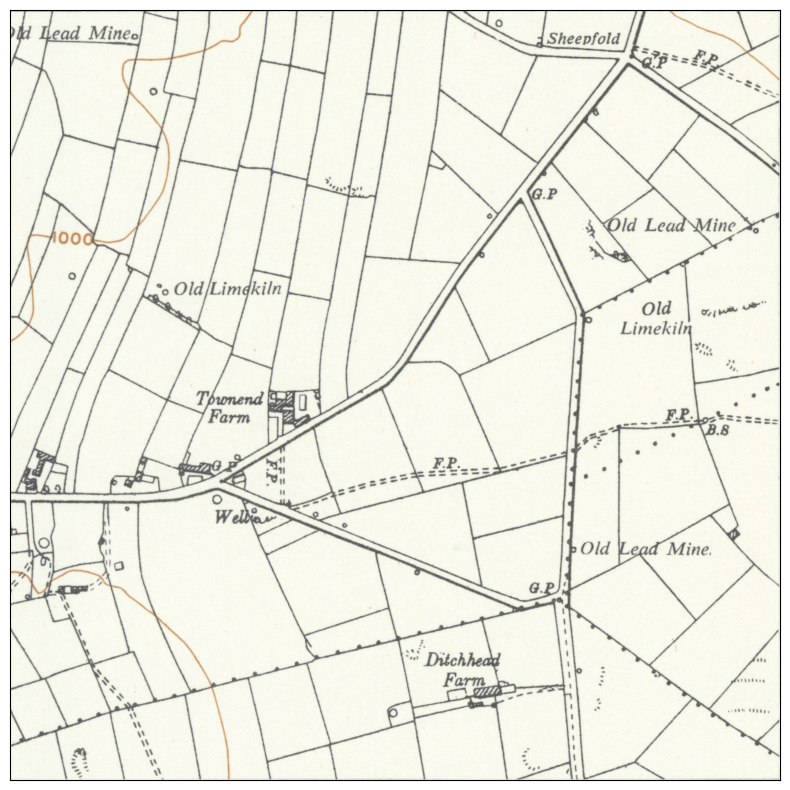

In [84]:
# Specify the correct output path for the PNG file
output = "../content/example_data/SK1468.png"

# Open the GeoTIFF file
with rasterio.open(lyr) as src:
    # Create a figure and axis to plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    # Use rasterio's show function to plot the image on the provided axis
    show(src, ax=ax)
    # Remove axis ticks and labels for a clean image
    ax.set_xticks([])
    ax.set_yticks([])
    # Save the figure as a PNG file
    plt.savefig(output, dpi=150, bbox_inches='tight', pad_inches=0)
    # Close the plot to free up memory
    plt.show()
    plt.close(fig)

#### 2) Text Mask

Looking for /home/david/.keras-ocr/craft_mlt_25k.h5
Looking for /home/david/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 2s 7ms/step
-- Detected 34 words or letters


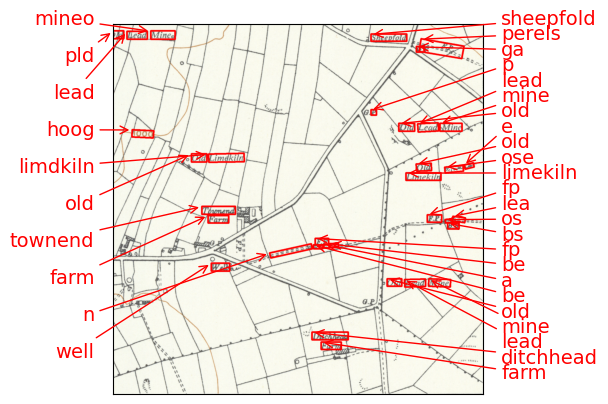

In [85]:
text_m = Text_Mask(lyr)
text_m = text_m.k_mask()

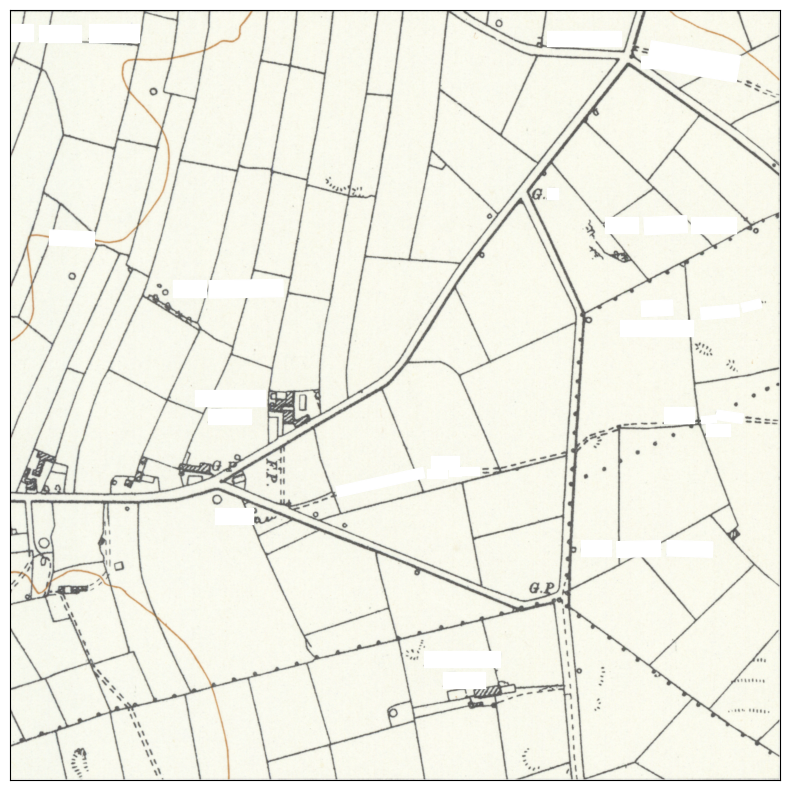

In [86]:
raster_plotter = RasterPlotter(lyr)
raster_plotter.plot_over_raster(text_m)

#### OS + Text Mask

In [22]:
collections = {
    'buildings': 'bld-fts-buildingpart-1',
    'sites': 'lus-fts-site-1', 
    'railways': 'trn-fts-rail-1', 
    'land': 'lnd-fts-land-1',
    'water': 'wtr-fts-waterpoint-1',
    'road': 'trn-fts-roadline-1',
    'track': 'trn-fts-roadtrackorpath-1',
    'waterlink': 'wtr-ntwk-waterlink-1',
    'waterlinkset': 'wtr-ntwk-waterlinkset-1'
}

subsets = {'Land': ['Made Surface', 'Residential Garden', 'Non-Coniferous Trees', 'Coniferous Trees', 'Mixed Trees']}

urban_m = CombinedMask(lyr, collections, subsets)

ngd_buildings query contains the following number of features:90
ngd_sites query contains the following number of features:16
railways query is empty!
ngd_land query contains the following number of features:260
water query is empty!
road query is empty!
ngd_track query contains the following number of features:58
waterlink query is empty!
waterlinkset query is empty!
-- Total OS Collections Data Set Contains: 424 values
-- Final Subsetted Data Set Contains: 242
Looking for /home/david/.keras-ocr/craft_mlt_25k.h5
Looking for /home/david/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 1s 7ms/step
-- Detected 34 words or letters


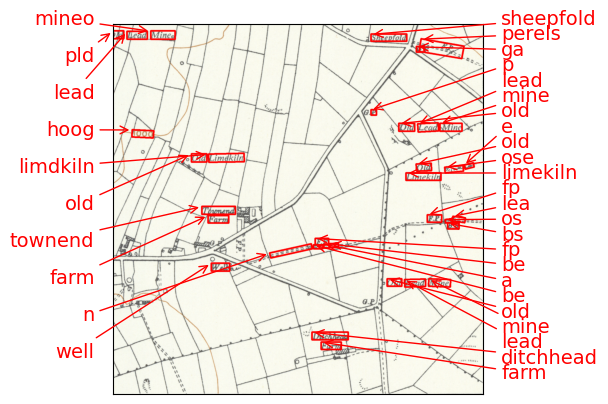

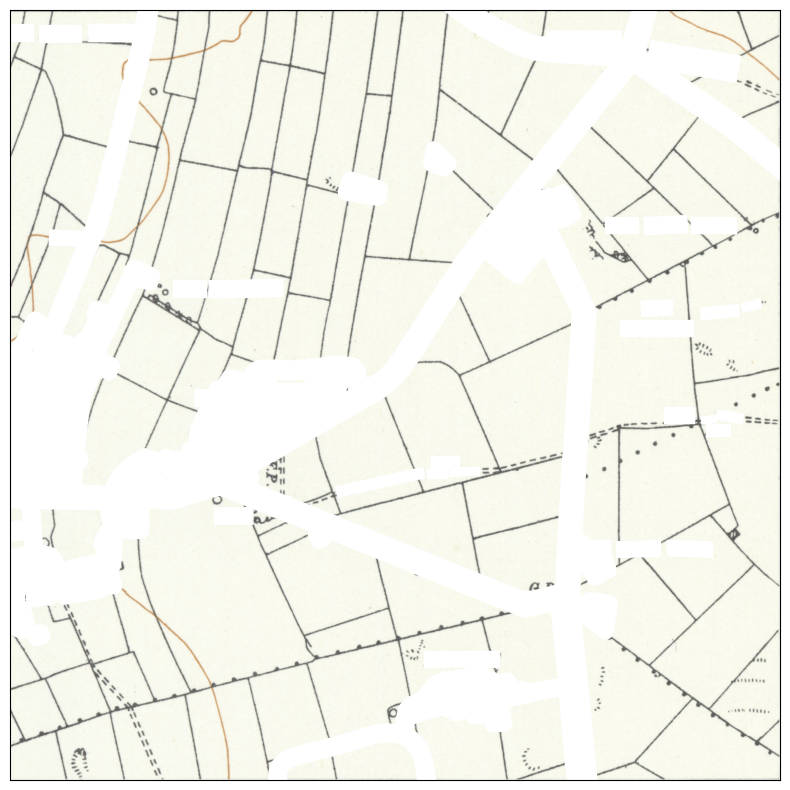

In [87]:
# Create the combined mask GeoDataFrame
urban_gdf = urban_m.create_combined_mask()
raster_plotter = RasterPlotter(lyr)
raster_plotter.plot_over_raster(urban_gdf)

#### MapReader

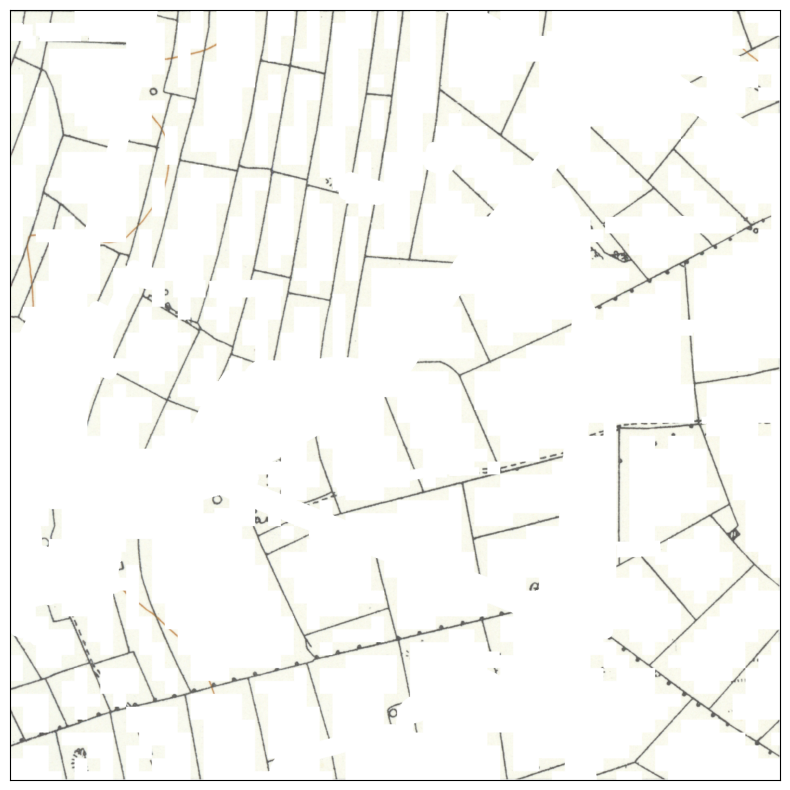

In [88]:
#### See https://github.com/pdnpa/cnn-boundaries/blob/main/notebooks/map-reader.ipynb

# Path to the original GeoTIFF file
original = "../content/tifs/mapreader_masks/SK1468_mapreader_mask.tif"

# Specify the correct output path for the PNG file
output = "../content/example_data/SK1468_mapreader.png"

# Open the GeoTIFF file
with rasterio.open(original) as src:
    # Create a figure and axis to plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    # Use rasterio's show function to plot the image on the provided axis
    show(src, ax=ax)
    # Remove axis ticks and labels for a clean image
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.title('MapReader Mask')
    # Save the figure as a PNG file
    plt.savefig(output, dpi = 150, bbox_inches='tight', pad_inches=0)
    # Close the plot to free up memory
    plt.show()
    plt.close(fig)

#### Line Mask > Binarise Image > Canny Edges > Probabilistic Hough Tansform

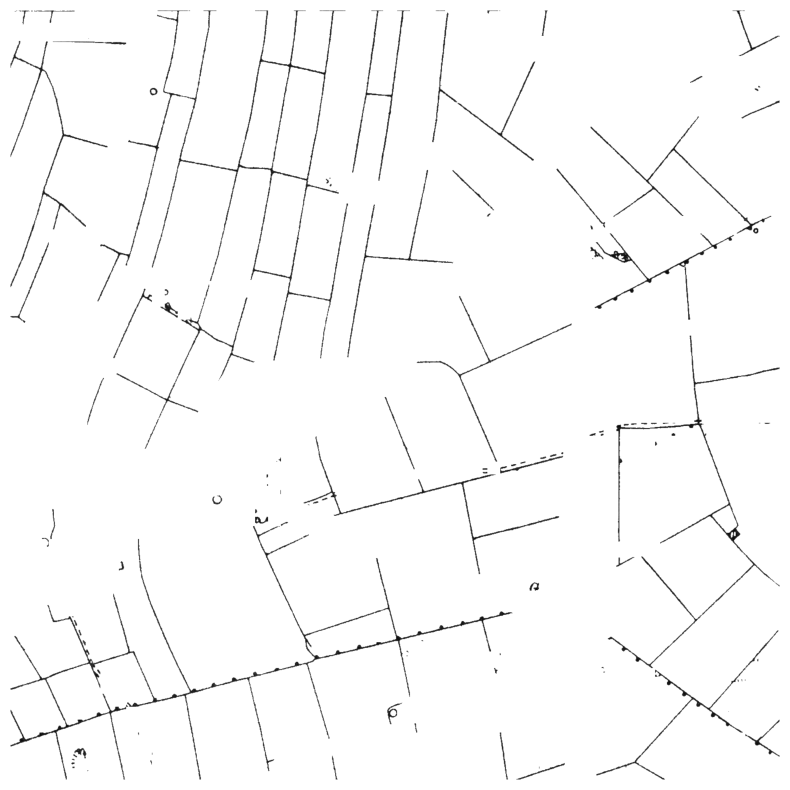

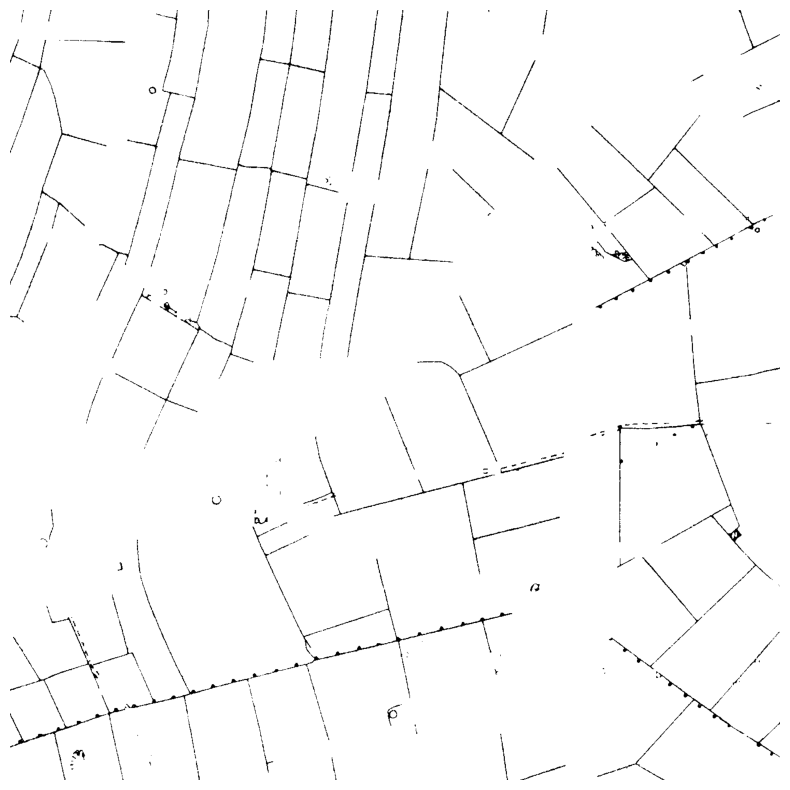

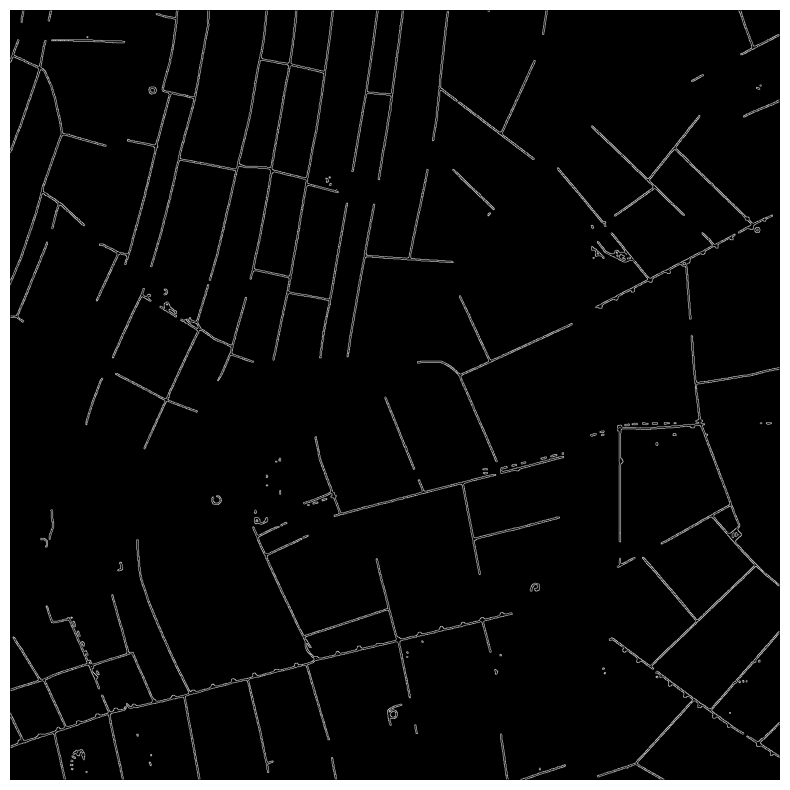

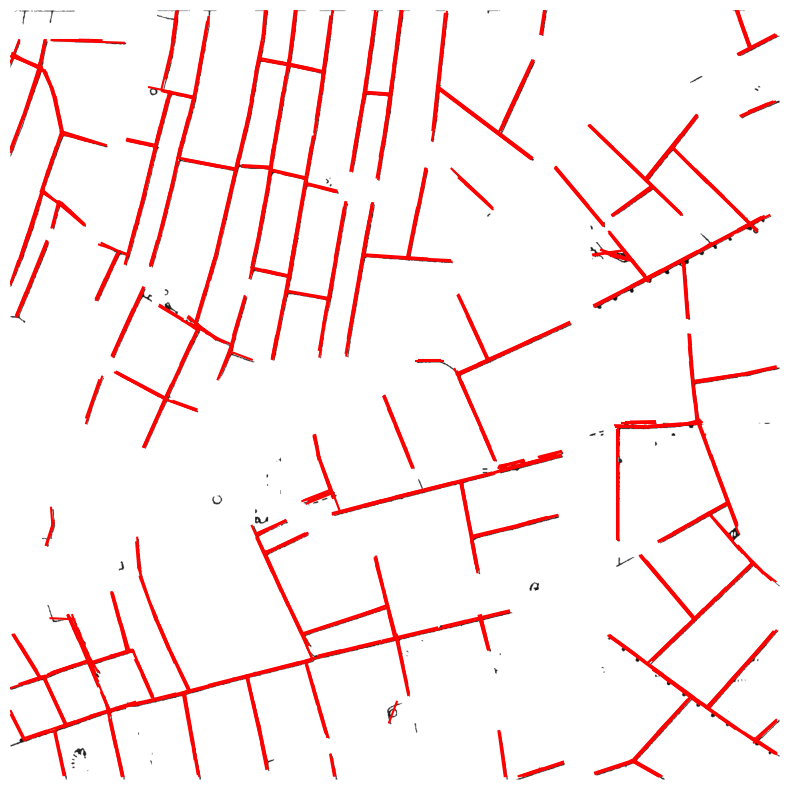

In [99]:
hwi.visualize_process_separately("../content/tifs/line_masks/SK1468_mapreader_mask.tif", '../content/example_data/SK1468_')

# First test of Hough Transform

/tmp/ipykernel_3083/34272638.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


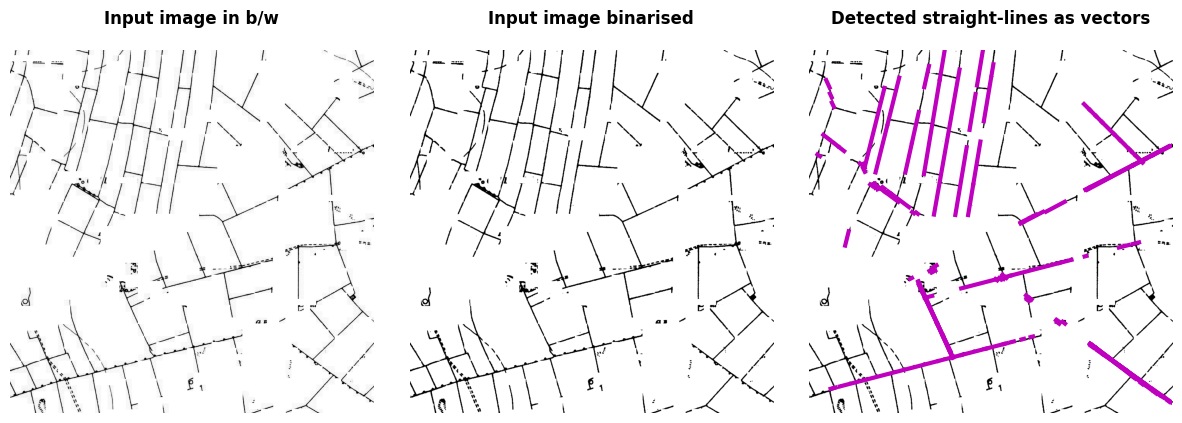

In [9]:
# Load the image
im = PIL.Image.open('../content/example_data/masked/example_screenshot_OS10000.png')
im = im.convert("L")
ima = np.asarray(im)

## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
arr = arr[5:-5 :][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()